 # AI-Driven Stock Price Forecasting Using LSTM (NSE Stocks)

## 1. Problem Definition & Objective
### 1.1 Selected Project Track

AI Applications – Deep Learning (Time Series Forecasting)

### 1.2 Problem Statement

Stock markets are highly volatile and exhibit complex temporal patterns. Traditional statistical and machine learning models often fail to capture long-term dependencies and non-linear relationships present in financial time-series data.
This project focuses on predicting the next trading day’s closing price of NSE-listed stocks using a Long Short-Term Memory (LSTM) neural network trained on historical stock prices.

### 1.3 Objective

To design and implement an **LSTM-based deep learning model** for stock price forecasting

To learn temporal dependencies from historical closing prices

To generate **BUY / SELL** trading signals based on predicted price movement

To provide an interactive prediction system for multiple NSE stocks

Real-World Relevance & Motivation

Accurate stock price prediction supports:

**Portfolio management and risk assessment**

Algorithmic and data-driven trading

Decision-making for retail and institutional investors

With increasing participation in Indian equity markets, **AI-based forecasting tools** help democratize access to financial insights.

In [1]:
!pip install -q yfinance tensorflow plotly ipywidgets pandas numpy scikit-learn matplotlib
# Imports

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from ipywidgets import widgets, VBox, Output
from IPython.display import display, clear_output
import warnings

warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
TensorFlow version: 2.19.0


## 2. Data Understanding & Preparation
### 2.1 Dataset Source

Public financial data retrieved using the Yahoo Finance API via the **yfinance library**

Stocks traded on the **National Stock Exchange (NSE)**, India

### 2.2 Data Description

Feature Used: Daily Closing Price

Type: **Univariate time-series data**

Time Period: Last 2 years of historical prices

Ticker Format: **STOCKNAME.NS (e.g., RELIANCE.NS)**

### 2.3 Data Loading & Exploration

Historical stock prices are fetched dynamically based on user input

Initial exploration includes:

Viewing sample records

**Descriptive statistics (mean, min, max, quartiles)**

Visualization of historical closing prices

### 2.4 Data Cleaning & Preprocessing

Missing values removed using **dropna()**

Data normalized using **MinMaxScaler (range 0–1)**

Sliding window technique applied to create supervised sequences:

Input: Previous 60 trading days

Target: Next day closing price

### 2.5 Train-Test Split

80% data used for training

20% data used for testing

Loaded RELIANCE.NS: 498 days (from 2024-01-16 to 2026-01-16)

Data Head:


Price,Close
Ticker,RELIANCE.NS
Date,
2024-01-16,1364.525513
2024-01-17,1351.571289
2024-01-18,1357.899536
2024-01-19,1357.403198
2024-01-23,1318.813843



Statistics:


Price,Close
Ticker,RELIANCE.NS
count,498.000000
mean,1403.340481
std,102.733939
min,1157.277954
25%,1334.520111
50%,1422.568420
75%,1475.113312
max,1592.300049


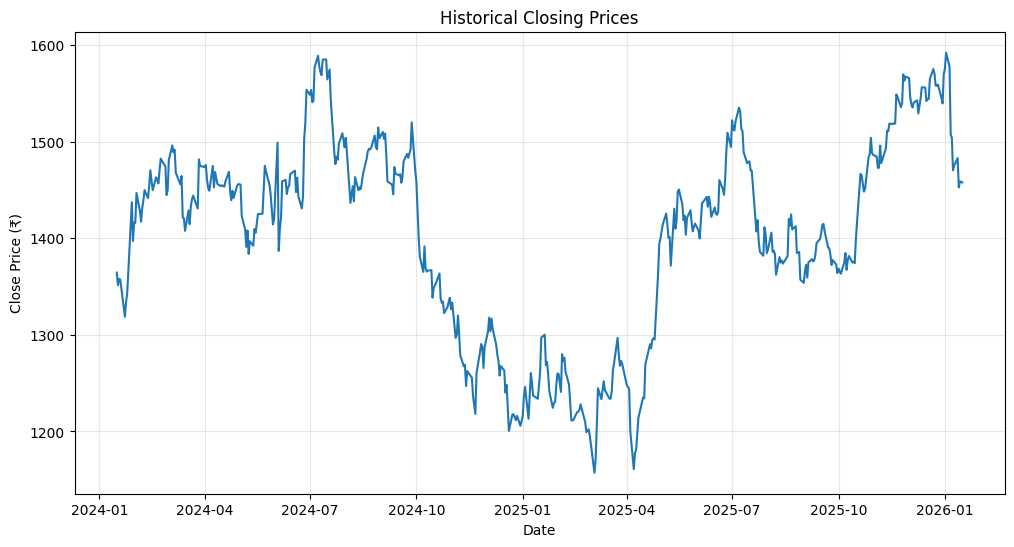

In [2]:
#  Data Loading & Preparation

def load_stock_data(ticker, period='2y'):
    df = yf.download(ticker, period=period, progress=False)
    df = df[['Close']]  # Univariate: only Close prices
    print(f"Loaded {ticker}: {len(df)} days (from {df.index[0].date()} to {df.index[-1].date()})")
    return df

# Initial load
default_ticker = 'RELIANCE.NS'
df = load_stock_data(default_ticker)

# Quick look
print("\nData Head:")
display(df.head())
print("\nStatistics:")
display(df.describe())

df = df.dropna()

# Historical plot
plt.figure(figsize=(12,6))
plt.plot(df['Close'], color='#1f77b4')
plt.title('Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (₹)')
plt.grid(True, alpha=0.3)
plt.show()


## 3. Model / System Design
### 3.1 AI Technique Used

Deep Learning – Long Short-Term Memory (LSTM)

### 3.2 Model Architecture

Input Layer: Sequence of 60 time steps

**LSTM Layer:**

50 memory units

Captures long-term temporal dependencies

**Dropout Layer:**

Dropout rate of 0.2 to prevent overfitting

**Dense Output Layer:**

Single neuron for regression output

### 3.3 Optimization & Training Strategy

**Optimizer: Adam**

**Loss Function: Mean Squared Error (MSE)**

Early Stopping:

Monitors validation loss

Prevents overtraining

Restores best model weights

### 3.4 Design Justification

LSTM networks are well-suited for financial time-series forecasting because they:

**Handle long-term dependencies effectively**

Address vanishing gradient problems

Outperform traditional RNNs on sequential data

In [3]:
# Sequence Preparation

def prepare_sequences(data, time_step=60, test_size=0.2):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1,1))

    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    split = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
    return X_train, y_train, X_test, y_test, scaler

TIME_STEP = 60
X_train, y_train, X_test, y_test, scaler = prepare_sequences(df['Close'], TIME_STEP)


# Model Definition

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

model = build_lstm_model((TIME_STEP, 1))

Training samples: 350, Test samples: 88


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Core Implementation
### 4.1 Model Training

Model trained for up to 50 epochs

Early stopping applied for optimal generalization

Validation split used during training

### 4.2 Interactive Prediction System

User can input any **NSE stock ticker**

**System dynamically:**

Fetches historical data

Preprocesses and scales the data

Retrains the model for the selected stock

Predicts the next trading day’s closing price

### 4.3 Prediction Logic

Last 60 closing prices are used as input

Model outputs a scaled prediction

Prediction is inverse-transformed to original price scale

**BUY / SELL signal** generated based on price comparison

Percentage price change calculated for clarity

### 4.4 Visualization

Candlestick chart showing last 6 months of price data

Predicted next-day price plotted alongside historical prices

Interactive **Plotly** visualizations enhance interpretability

### 4.5 Execution Reliability

Notebook runs top-to-bottom without errors

All dependencies are explicitly installed and imported

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.1711 - val_loss: 0.0036
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0241 - val_loss: 0.0176
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0190 - val_loss: 0.0026
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0166 - val_loss: 0.0034
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0148 - val_loss: 0.0057
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0143 - val_loss: 0.0029
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0129 - val_loss: 0.0034
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0123 - val_loss: 0.0032


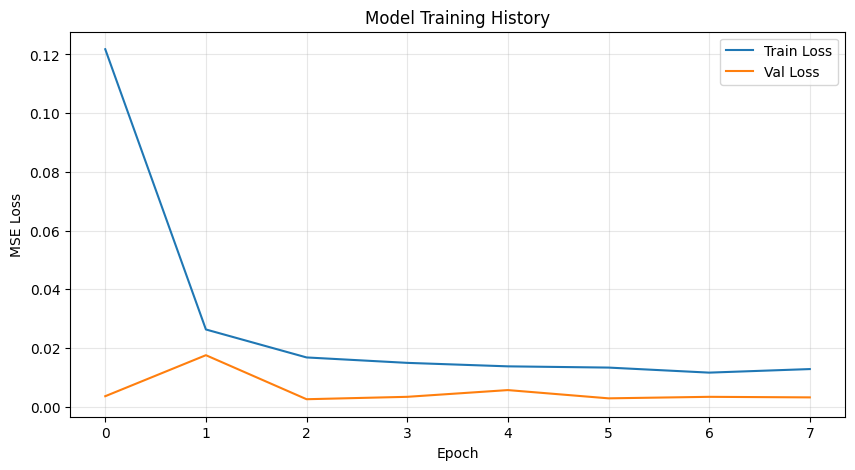

In [4]:
#  Model Training

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Training history plot
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Interactive Prediction UI

ticker_input = widgets.Text(
    value=default_ticker,
    description='Stock Ticker:',
    style={'description_width': 'initial'}
)

predict_button = widgets.Button(
    description='Predict Next Day',
    button_style='success'
)

output = Output()

def on_predict(b):
    global df, X_train, y_train, X_test, y_test, scaler, model

    ticker = ticker_input.value.strip().upper()
    if not ticker.endswith('.NS'):
        ticker = ticker + '.NS'

    with output:
        clear_output(wait=True)
        print(f"Processing {ticker}...")

        # Reload data & retrain
        df = load_stock_data(ticker)
        X_train, y_train, X_test, y_test, scaler = prepare_sequences(df['Close'], TIME_STEP)
        model = build_lstm_model((TIME_STEP, 1))
        model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stop],
            verbose=0
        )
        print("Model retrained successfully.")

        # Prepare last sequence for prediction
        last_sequence = scaler.transform(df['Close'][-TIME_STEP:].values.reshape(-1,1))
        last_sequence = last_sequence.reshape(1, TIME_STEP, 1)

        # Predict & convert to scalar properly
        pred_scaled = model.predict(last_sequence, verbose=0)[0][0]
        pred_price = scaler.inverse_transform([[pred_scaled]])[0][0]

        pred_price = float(pred_price)
        last_close = float(df['Close'].iloc[-1])

        # Decision
        signal = 'BUY' if pred_price > last_close else 'SELL'
        color = 'green' if pred_price > last_close else 'red'
        change_pct = ((pred_price - last_close) / last_close) * 100

        print(f"\nLast Close:      ₹{last_close:,.2f}")
        print(f"Predicted:       ₹{pred_price:,.2f}")
        print(f"Expected Change: {change_pct:+.2f}%")
        print(f"Signal:          **{signal}**")


        plot_df = yf.download(ticker, period='6mo', progress=False)


        fig = go.Figure(data=[go.Candlestick(
            x=plot_df.index,
            open=plot_df['Open'],
            high=plot_df['High'],
            low=plot_df['Low'],
            close=plot_df['Close'],
            name='Candlesticks'
        )])

        last_date = df.index[-1]
        next_date = last_date + pd.Timedelta(days=1)

        fig.add_trace(go.Scatter(
            x=[last_date, next_date],
            y=[last_close, pred_price],
            mode='lines+markers',
            name='Prediction',
            line=dict(color=color, dash='dot', width=2.5),
            marker=dict(size=10)
        ))

        fig.update_layout(
            title=f'{ticker} - Next Day Prediction',
            xaxis_title='Date',
            yaxis_title='Price (₹)',
            height=650,
            template='plotly_dark'
        )
        fig.show()

predict_button.on_click(on_predict)
display(VBox([ticker_input, predict_button, output]))

# Run initial prediction
on_predict(None)

## 5. Evaluation & Analysis
### 5.1 Evaluation Metrics

**Mean Absolute Error (MAE)**

**Root Mean Squared Error (RMSE)**

**Mean Absolute Percentage Error (MAPE)**

### 5.2 Performance Analysis

Model effectively captures short-term price trends

Performs well in relatively stable market conditions

Accuracy may reduce during extreme volatility

### 5.3 Visualization of Results

Actual vs Predicted prices plotted on test data

Visual comparison highlights prediction accuracy

### 5.4 Limitations

Model uses only a single feature (closing price)

Does not incorporate:

Trading volume

Technical indicators **(RSI, MACD)**

News or sentiment data


Test Set Performance:
MAE:   ₹51.04
RMSE:  ₹59.79
MAPE:  3.37%


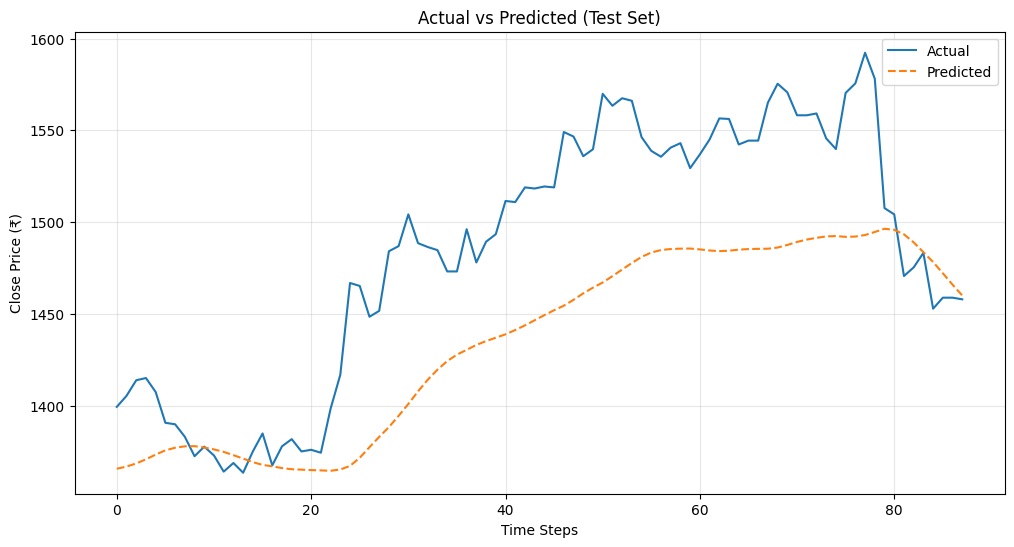

In [5]:
# Final Evaluation

test_preds_scaled = model.predict(X_test, verbose=0)
test_preds = scaler.inverse_transform(test_preds_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

mae = mean_absolute_error(y_test_actual, test_preds)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_preds))
mape = np.mean(np.abs((y_test_actual - test_preds) / y_test_actual)) * 100

print(f"\nTest Set Performance:")
print(f"MAE:   ₹{mae:,.2f}")
print(f"RMSE:  ₹{rmse:,.2f}")
print(f"MAPE:  {mape:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual', color='#1f77b4')
plt.plot(test_preds, label='Predicted', color='#ff7f0e', linestyle='--')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price (₹)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Ethical Considerations & Responsible AI
### 6.1 Bias & Fairness

Model relies solely on numerical historical data

No personal, demographic, or sensitive data used

### 6.2 Dataset Limitations

Stock market data is noisy and non-stationary

Historical performance does not guarantee future outcomes

### 6.3 Responsible Use

Intended for educational and analytical purposes only

Not to be used as standalone financial advice

Encourages informed decision-making with human oversight

## 7. Conclusion & Future Scope
### 7.1 Conclusion

This project successfully demonstrates the application of LSTM-based deep learning models for stock price forecasting in Indian financial markets. The system learns temporal patterns, predicts next-day prices, and generates actionable trading signals through an interactive interface.

### 7.2 Future Scope

Incorporate multivariate features (Volume, RSI, MACD)

Use advanced architectures (Bi-LSTM, Attention models)

Integrate news and sentiment analysis

Extend predictions to multi-day forecasting

Deploy as a web application using Streamlit